Costa Rican Household Group Project Submission by - Rajkumar, Jagadeeswaran and Saravanan 

# 1.0 Clear memory

In [139]:
%reset -f

# 1.1 Import ALL libraries


In [140]:
from time import time
import pandas as pd
import numpy as np
from sklearn.random_projection import SparseRandomProjection as sr  # Projection features
from sklearn.cluster import KMeans                    # Cluster features
from sklearn.preprocessing import PolynomialFeatures  # Interaction features
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import os, time, gc
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import auc, roc_curve
from eli5.sklearn import PermutationImportance
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
import h2o
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from xgboost.sklearn import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from xgboost import plot_importance
from sklearn.model_selection import cross_val_score
import eli5
from eli5.sklearn import PermutationImportance
import time
import os
import gc
import random
from scipy.stats import uniform
from sklearn.ensemble import GradientBoostingClassifier as gbm
from bayes_opt import BayesianOptimization
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV


# 2.0 Set working directory and read file

In [141]:
import os
import pandas as pd
os.chdir("../input")
print(os.listdir("../input"))

['test.csv', 'train.csv', 'sample_submission.csv']


# 2.1 Read train/test files

In [142]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [143]:
train.shape, test.shape

((9557, 143), (23856, 142))

# 3.0 Data Visualization

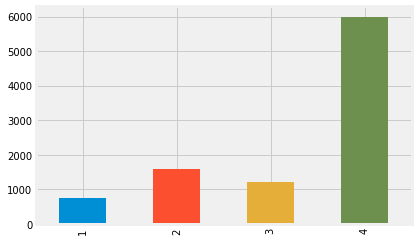

In [144]:

train['Target'].value_counts().sort_index().plot(kind='bar')

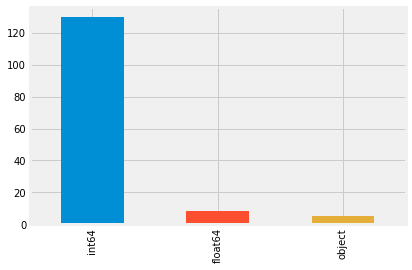

In [145]:
train.dtypes.value_counts().plot(kind='bar')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9123bb3550>,
      dtype=object)

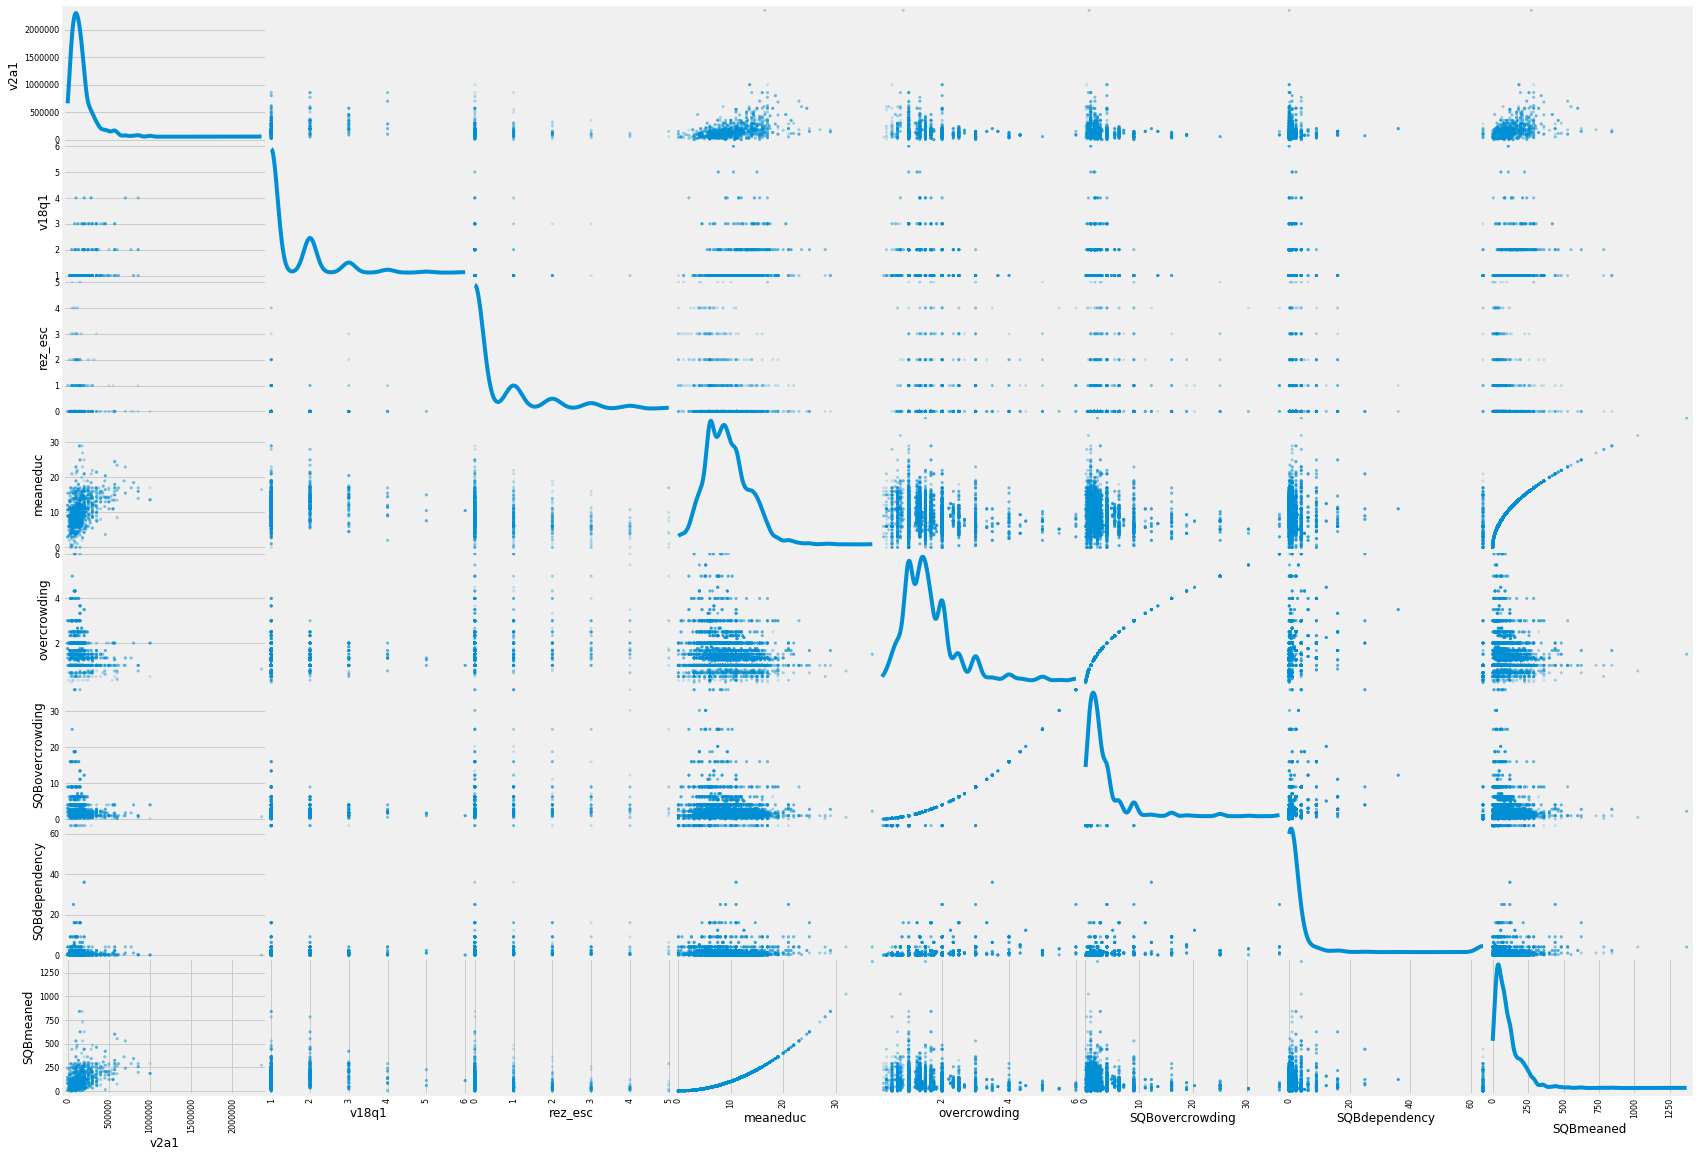

In [146]:
from pandas.plotting import scatter_matrix
scatter_matrix(train.select_dtypes('float'), alpha=0.2, figsize=(26, 20), diagonal='kde')

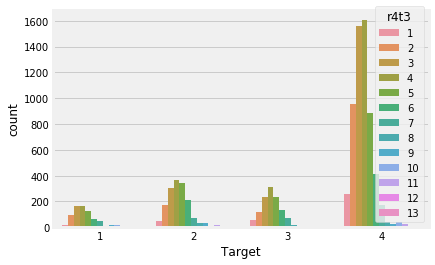

In [147]:
sns.countplot(data=train,
             x='Target',
             hue='r4t3')

In [148]:
trainPV = pd.pivot_table(train,index="Target", values=["r4t3"],aggfunc=np.mean)
trainPV

,r4t3
Target,
1,4.458278
2,4.370695
3,4.280397
4,3.796531


In [149]:
trainPVdf = trainPV.reset_index()
trainPVdf

,Target,r4t3
0,1,4.458278
1,2,4.370695
2,3,4.280397
3,4,3.796531


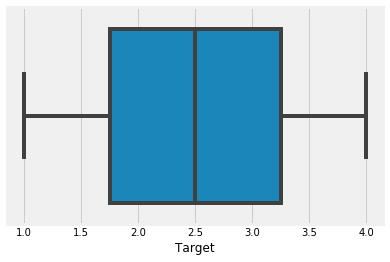

In [150]:
sns.boxplot(data=trainPV.reset_index(),
             x='Target',
             hue='r4t3')

In [151]:
train.dtypes.value_counts()

int64      130
float64      8
object       5
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9121d867f0>,
      dtype=object)

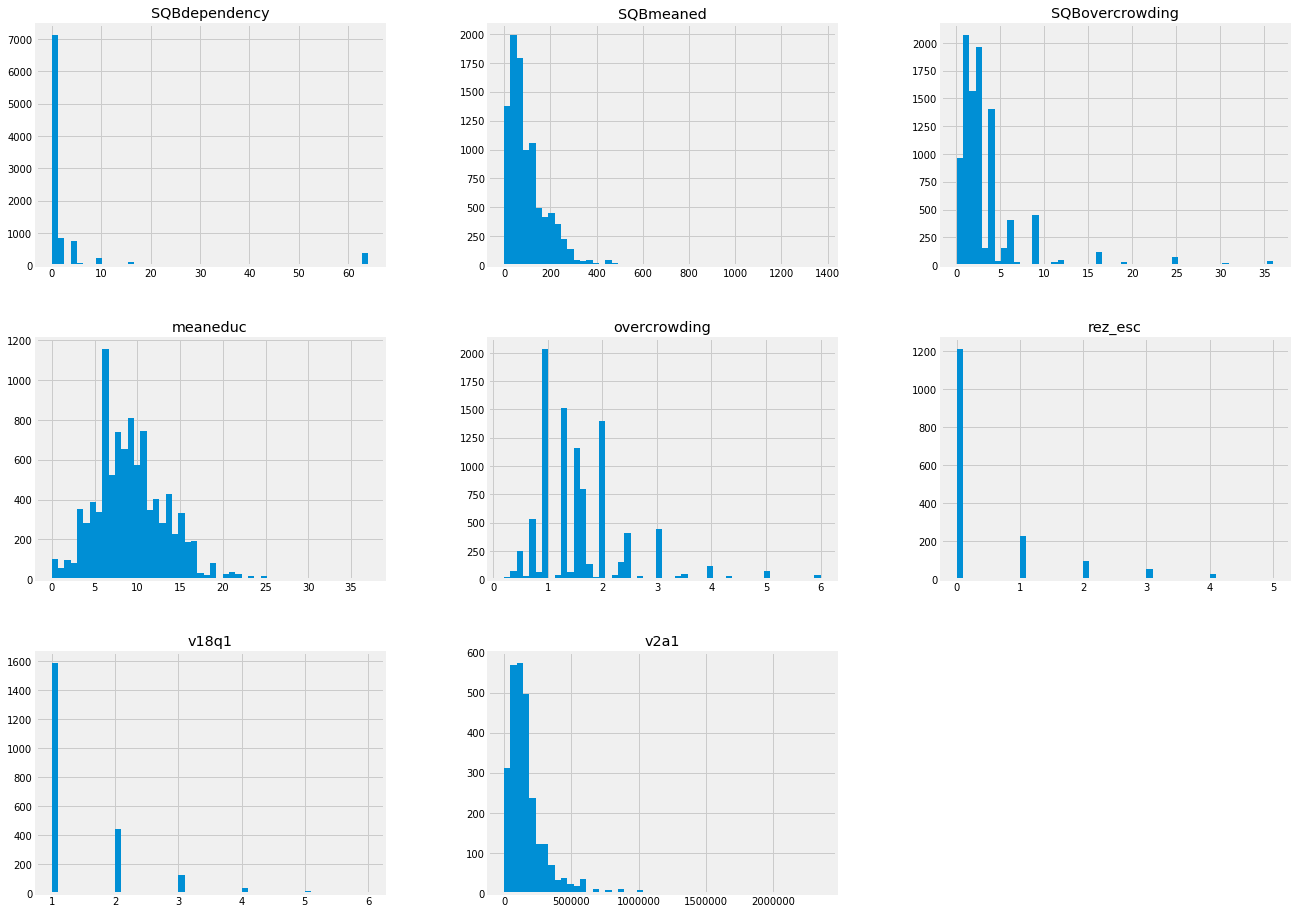

In [152]:
train.select_dtypes('float').hist(bins=50,figsize=(20,16))

In [153]:
train.select_dtypes('object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


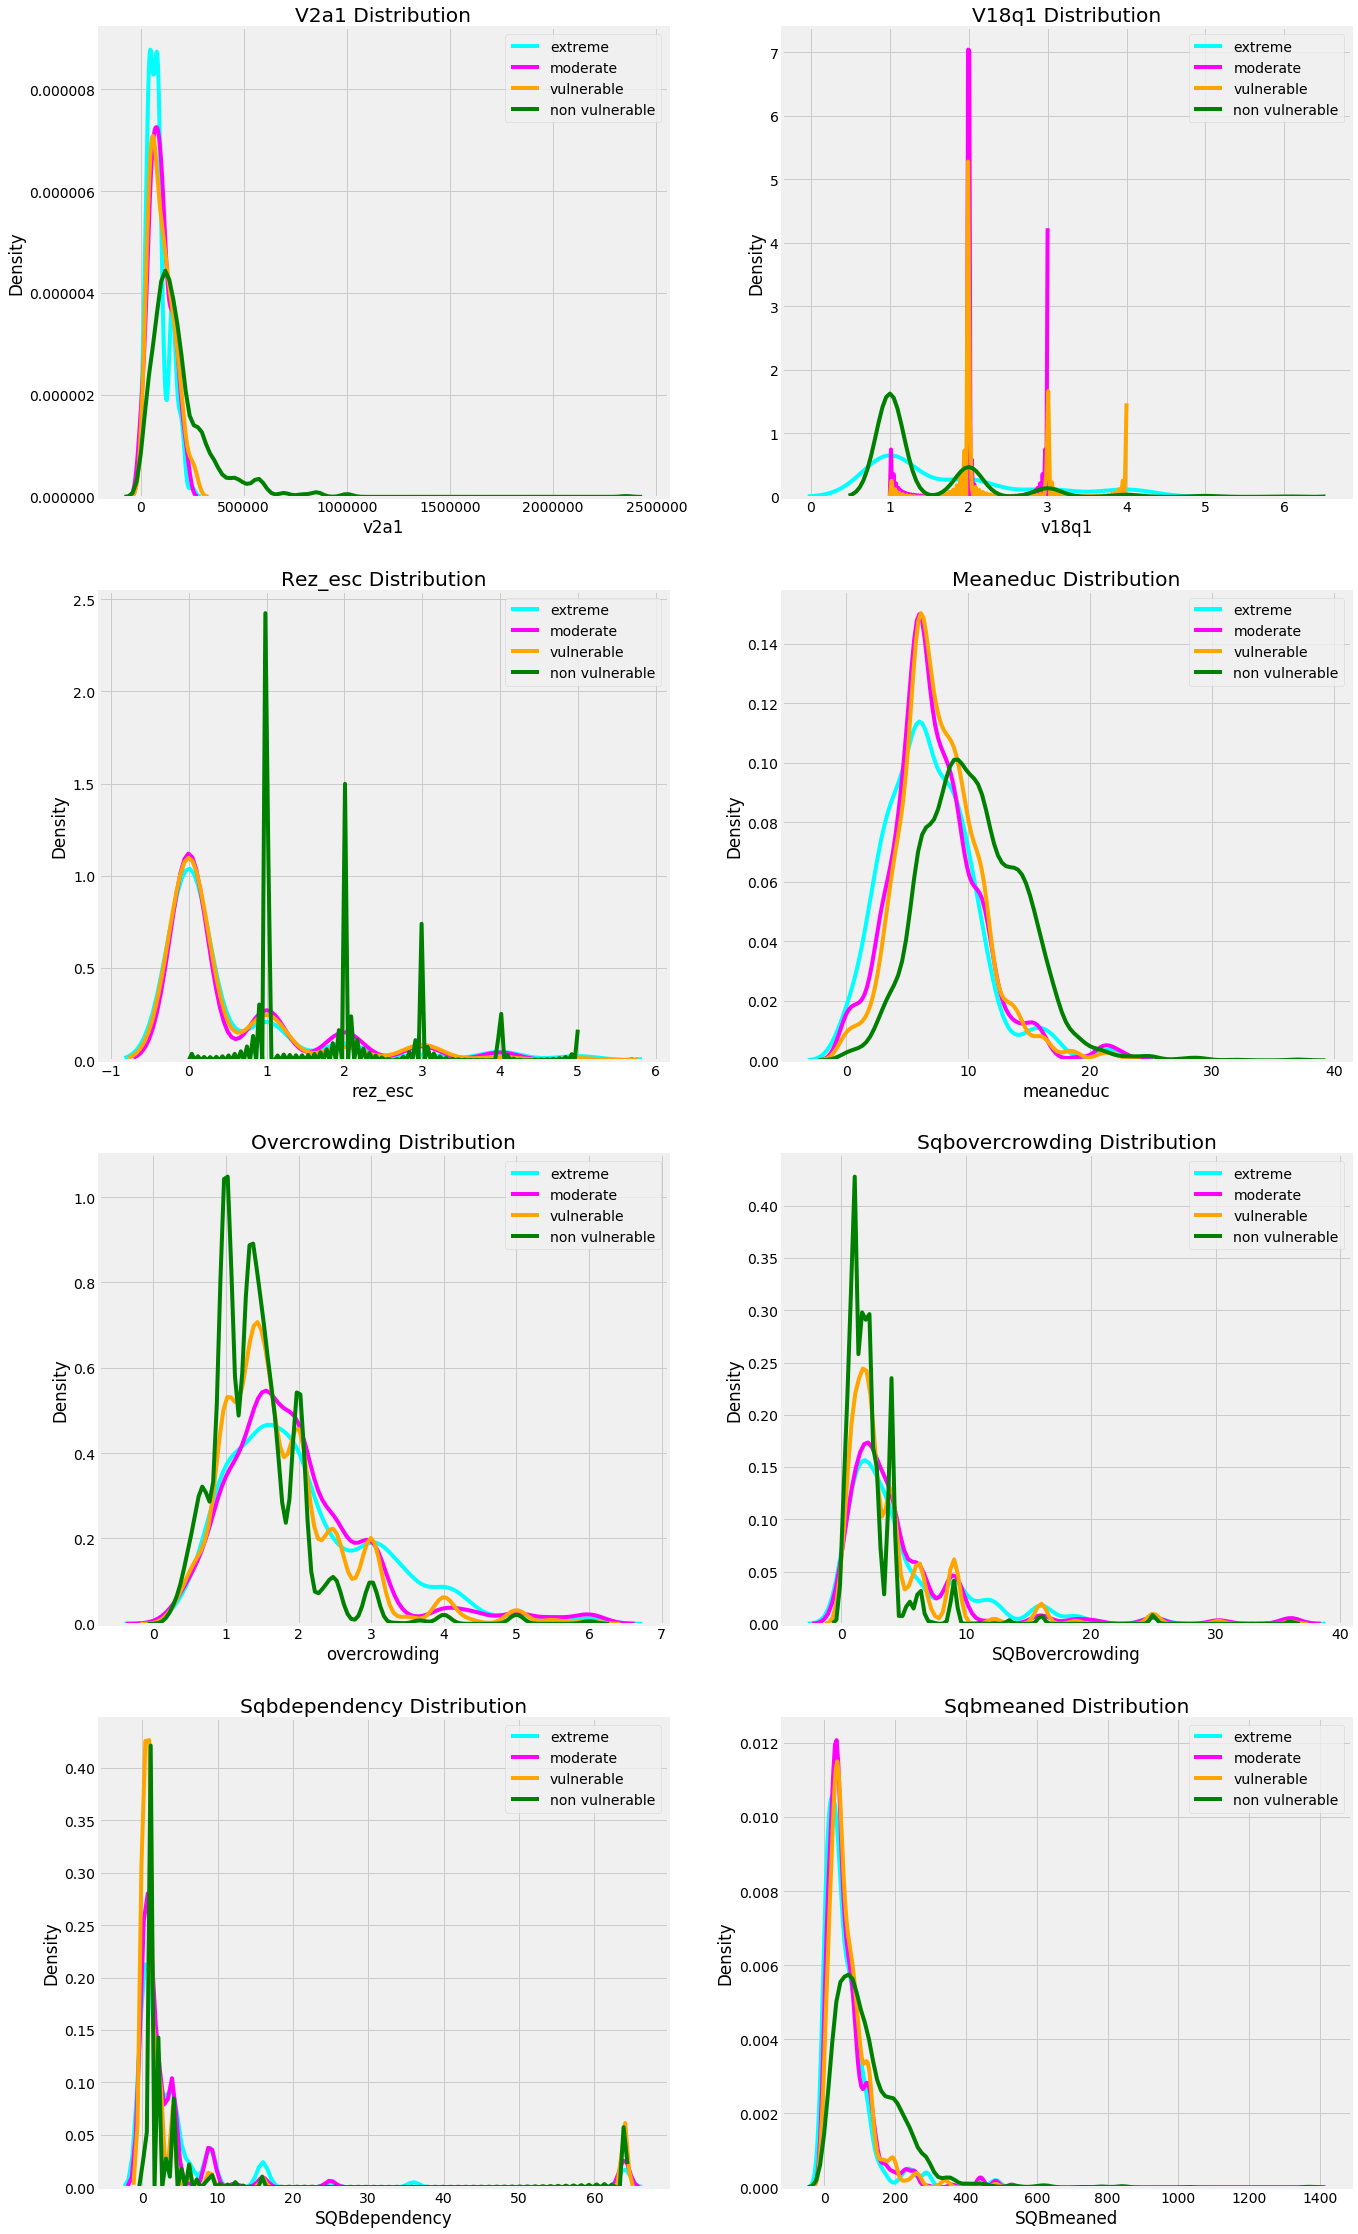

In [154]:
from collections import OrderedDict

plt.figure(figsize = (20, 16))
plt.style.use('fivethirtyeight')

# Color mapping
colors = OrderedDict({1: 'cyan', 2: 'magenta', 3: 'orange', 4: 'green'})
poverty_mapping = OrderedDict({1: 'extreme', 2: 'moderate', 3: 'vulnerable', 4: 'non vulnerable'})

# Iterate through the float columns
for i, col in enumerate(train.select_dtypes('float')):
    ax = plt.subplot(4, 2, i + 1)
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        # Plot each poverty level as a separate line
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), 
                    ax = ax, color = color, label = poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')

plt.subplots_adjust(top = 2)

# 3.1 Let us make operations to balance the values in columns and drop columns not needed 

In [155]:

train['dependency']=train['dependency'].replace(['yes','no'],[1,0]).astype(np.float64)
train['edjefe']=train['edjefe'].replace(['yes','no'],[1,0]).astype(np.float64)
train['edjefa']=train['edjefa'].replace(['yes','no'],[1,0]).astype(np.float64)
train.drop(columns = ['Id','idhogar'] , inplace = True)


In [156]:

test['dependency']=test['dependency'].replace(['yes','no'],[1,0]).astype(np.float64)
test['edjefe']=test['edjefe'].replace(['yes','no'],[1,0]).astype(np.float64)
test['edjefa']=test['edjefa'].replace(['yes','no'],[1,0]).astype(np.float64)
test.drop(columns = ['Id','idhogar'] , inplace = True)


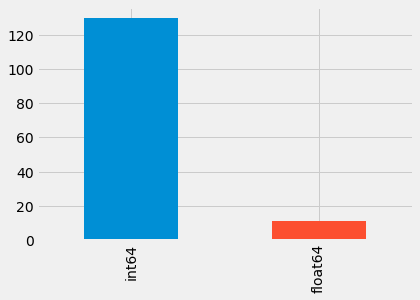

In [157]:
train.dtypes.value_counts().plot(kind='bar')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f911a235978>,
      dtype=object)

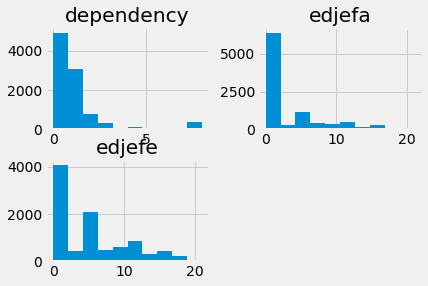

In [158]:
train[['dependency','edjefe','edjefa']].hist(bins=10)

# 3.2 Lets us deal the NaN in all columns of Train and Test

In [159]:
# Number of missing data in each column
missing = pd.DataFrame(train.isnull().sum()).rename(columns = {0: 'total'})
# Create a percentage missing
missing['percent'] = (missing['total'] / len(train)*100)
missing.sort_values('percent', ascending = False).head(10)

,total,percent
rez_esc,7928,82.954902
v18q1,7342,76.823271
v2a1,6860,71.779847
SQBmeaned,5,0.052318
meaneduc,5,0.052318
hogar_mayor,0,0.000000
parentesco10,0,0.000000
parentesco11,0,0.000000
parentesco12,0,0.000000
hogar_nin,0,0.000000


# 3.2.1 Let us Impute with MEAN of the column for the most missing Numeric values and MOST FREQUENT for the Object variables/categorical values.

In [160]:
imp = SimpleImputer(strategy="mean") 
train['rez_esc'] = imp.fit_transform(train[['rez_esc']])
train['v18q1'] = imp.fit_transform(train[['v18q1']])
train['v2a1'] = imp.fit_transform(train[['v2a1']])
train['SQBmeaned'] = imp.fit_transform(train[['SQBmeaned']])
train['meaneduc'] = imp.fit_transform(train[['meaneduc']])
test['rez_esc'] = imp.fit_transform(test[['rez_esc']])
test['v18q1'] = imp.fit_transform(test[['v18q1']])
test['v2a1'] = imp.fit_transform(test[['v2a1']])
test['SQBmeaned'] = imp.fit_transform(test[['SQBmeaned']])
test['meaneduc'] = imp.fit_transform(test[['meaneduc']])

In [161]:
# Number of missing data in each column
missing = pd.DataFrame(test.isnull().sum()).rename(columns = {0: 'total'})
# Create a percentage missing
missing['percent'] = (missing['total'] / len(test)*100)
missing.sort_values('percent', ascending = False).head(10)

,total,percent
v2a1,0,0.0
hogar_mayor,0,0.0
parentesco9,0,0.0
parentesco10,0,0.0
parentesco11,0,0.0
parentesco12,0,0.0
hogar_nin,0,0.0
hogar_adul,0,0.0
hogar_total,0,0.0
parentesco7,0,0.0


In [162]:
train.head()

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,...,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,190000.000000,0,3,0,1,1,0,1.404063,0,1,1,0,0,0,0,1,1,1,1,10,0.459791,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,...,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,135000.000000,0,4,0,1,1,1,1.000000,0,1,1,0,0,0,0,1,1,1,1,12,0.459791,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,...,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,165231.606971,0,8,0,1,1,0,1.404063,0,0,0,0,1,1,0,1,1,1,1,11,0.459791,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,...,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,180000.000000,0,5,0,1,1,1,1.000000,0,2,2,1,1,2,1,3,4,4,4,9,1.000000,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,...,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,180000.000000,0,5,0,1,1,1,1.000000,0,2,2,1,1,2,1,3,4,4,4,11,0.459791,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,...,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [163]:
train.shape, test.shape

((9557, 141), (23856, 140))

In [164]:
train.isnull().sum().sum() , test.isnull().sum().sum()   # 0



(0, 0)

# 3.3 Seperate Target from train dataset

In [165]:
target=train['Target']

In [166]:
train.drop('Target', inplace = True, axis = 1)


# 4.0 Feature Engineering

# Since we are shooting in the dark with very less understanding of data;  Let us create other statistical features and perform Feature Engineering

In [167]:
train.shape, test.shape

((9557, 140), (23856, 140))

In [ ]:
train.head()

# 4.1 Statistical Features

In [ ]:
feat = [ "var", "median", "mean", "std", "max", "min"]
for i in feat:
    train[i] = train.aggregate(i,  axis =1)
    test[i]  = test.aggregate(i,axis = 1)

In [ ]:
train.shape, test.shape

# 4.2 Feature creation Using Random Projections

In [ ]:
tmp = pd.concat([train,test],
                axis = 0,            # Stack one upon another (rbind)
                ignore_index = True
                )

In [ ]:
tmp.head()

In [ ]:
#tmp.drop(['idhogar'],axis=1,inplace=True)
#tmp.drop(['Id'],axis=1,inplace=True)

In [ ]:
# Let us create 10 random projections/columns
NUM_OF_COM = 10 
# 13.1 Create an instance of class
rp_instance = sr(n_components = NUM_OF_COM)


In [ ]:
rp = rp_instance.fit_transform(tmp.iloc[:, :147])

In [ ]:
# Transfrom resulting array to pandas dataframe
# Also assign column names
rp = pd.DataFrame(rp, columns = ['r1','r2','r3','r4', 'r5', 'r6', 'r7', 'r8', 'r9', 'r10'] )
rp.head()   # Default column names are 0,1,2...9

In [ ]:
# 13.4 Concat the new columns to tmp
tmp = np.hstack((tmp,rp))
tmp.shape

# 4.3 Polynomial Features

In [ ]:
poly = PolynomialFeatures(2,                      # Degree 2
                          interaction_only=True,  # Avoid e.g. square(a)
                          include_bias = False   # No constant term
                          )

In [ ]:
df =  poly.fit_transform(tmp[:, : 6])

In [ ]:
df.shape

In [ ]:
c_names = []
p = "p"
for i in range(21):
    t = p + str(i)
    c_names.append(t)


In [ ]:
tmp = np.hstack([tmp,df])
tmp.shape     

# 5 Create Final Train/Test + Split Train into training and validation dataset


In [ ]:
# Separate train and test
X = tmp[: train.shape[0], : ]
test = tmp[train.shape[0] :, : ]

X.shape , test.shape                            

In [ ]:
del tmp
gc.collect()

In [ ]:
X_copy=X
X_copy.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,target,test_size = 0.2)



In [ ]:
X_train.shape  ,X_test.shape, y_train.shape, y_test.shape

# 6 Dimesionality Reduction : Since there are 177 estimators; let us reduce the dimensionality before proceeding with modeling. Let us try PCA but Before PCA, data must be standardized



# 6.1 Standardizing the Data

In [ ]:
scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train)
X_test_scaled = scale.fit_transform(X_test)

In [ ]:
type(X_train_scaled), X_train_scaled.shape

# 6.2 Perform pca

In [ ]:
pca=PCA().fit(X_train_scaled)
pca

In [ ]:
type(pca)

In [ ]:
len(pca.components_[0])


In [ ]:
np.sum(pca.components_[0]**2)

In [ ]:
print(len(pca.explained_variance_ratio_))

In [ ]:
def pca_summary(pca, standardized_data, out=True):
    names = ["PC"+str(i) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    a = list(np.std(pca.transform(standardized_data), axis=0))
    b = list(pca.explained_variance_ratio_)
    c = [np.sum(pca.explained_variance_ratio_[:i]) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    columns = pd.MultiIndex.from_tuples([("sdev", "Standard deviation"), ("varprop", "Proportion of Variance"), ("cumprop", "Cumulative Proportion")])
    summary = pd.DataFrame(list(zip(a, b, c)), index=names, columns=columns)
    
    if out:
        print("Importance of components:")
        display(summary)
    return summary

In [ ]:
Summary = pca_summary(pca, X_train_scaled)

In [ ]:
def screeplot(pca, standardized_values):
    y = np.std(pca.transform(standardized_values), axis=0)**2
    x = np.arange(len(y)) + 1
    plt.figure(figsize=(20,10))
    plt.plot(x, y, "o-")
    plt.xticks(x, ["Comp."+str(i) for i in x], rotation=60)
    plt.ylabel("Variance")
    plt.show()

In [ ]:
screeplot(pca, X_train_scaled)

In [ ]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

In [ ]:
pca=PCA(n_components=d)
X_train_reduced=pca.fit_transform(X_train_scaled)
X_test_reduced=pca.fit_transform(X_test_scaled)

In [ ]:
X_train_reduced.shape, X_train_scaled.shape, X_test_reduced.shape, X_test_scaled.shape

In [ ]:
X_train_reduced

In [ ]:
%matplotlib inline

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(cumsum)

# 7 Model Training : Now that the data is scaled and with reduced dimensions; let us do some Model Training.


In [ ]:
X_train_reduced.shape,y_train.shape

# 7.1 H2O Modeling

In [ ]:
h2o.init()

In [ ]:
train_h2o =h2o.import_file("train.csv")
test_h2o =h2o.import_file("test.csv")

In [ ]:
type(train_h2o), type(test_h2o)

In [ ]:
train_h2o['Target'] = train_h2o['Target'].asfactor()

In [ ]:
train_h2o['Target'].levels()

In [ ]:
trainh,testh = train_h2o.split_frame(ratios= [0.7])
trainh.shape, testh.shape

In [ ]:
trainh_columns = trainh.columns[0:142] 
y_columns = trainh.columns[142] 

In [ ]:
trainh['Target'] = trainh['Target'].asfactor()

In [ ]:
h2o_model = H2ODeepLearningEstimator(epochs=1000,
                                    distribution = 'bernoulli',                 # Response has two levels
                                    missing_values_handling = "MeanImputation", # Not needed by us
                                    variable_importances=True,
                                    nfolds = 2,                           # CV folds
                                    fold_assignment = "Stratified",       # Each fold must be sampled carefully
                                    keep_cross_validation_predictions = True,  # For analysis
                                    balance_classes=False,                # SMOTE is not provided by h2o
                                    standardize = True,                   # z-score standardization
                                    activation = 'RectifierWithDropout',  # Default dropout is 0.5
                                    hidden = [100,100],                  # ## more hidden layers -> more complex interactions
                                    stopping_metric = 'logloss',
                                    loss = 'CrossEntropy')

In [ ]:
import time
from time import time

In [ ]:
start = time()
h2o_model.train(trainh_columns,
               y_columns,
               training_frame = trainh)
end = time()
(end - start)/60

In [ ]:
print(h2o_model)

In [ ]:
# 5.3 Column importance:
h2o_model_imp = pd.DataFrame(h2o_model.varimp(),
             columns=["Variable", "Relative Importance", "Scaled Importance", "Percentage"])

In [ ]:
h2o_model_imp.head(20)

# 7.2 XGBoost Classifier

In [ ]:
XGBCLF= XGBClassifier(silent = False,n_jobs=2)

# We will use the already scaled and reduced dimension data. 

In [ ]:
X_train_reduced.shape,y_train.shape, X_test_reduced.shape, y_test.shape

In [ ]:
XGBCLF.fit(X_train_reduced,y_train)

In [ ]:
XGBCLF.get_params

In [ ]:
XGB_pred = XGBCLF.predict(X_test_reduced)

In [ ]:
##Accuracy of model.
(XGB_pred==y_test).sum()/(y_test.size)*100

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test,XGB_pred))

In [ ]:
XGBCLF.feature_importances_

In [ ]:
plot_importance(XGBCLF,max_num_features=15)

In [ ]:
pd.DataFrame({'Feature Importance':XGBCLF.feature_importances_}).sort_values(by = "Feature Importance", ascending=False)

# 7.3 Gradient Boosting Classifier

In [ ]:
GBM=gbm()


In [ ]:
start = time()
GBM.fit(X_train_reduced,y_train)
end = time()
(end-start)/60

In [ ]:
GBM_pred = GBM.predict(X_test_reduced) 

In [ ]:
##Accuracy of model.
(GBM_pred ==y_test).sum()/(y_test.size)*100

In [ ]:
print(classification_report(y_test,GBM_pred))

# 7.4 Random Forest Classifier

In [ ]:
RanForCLF = RandomForestClassifier(random_state=42)
start = time()
RanForCLF.fit(X_train_reduced,y_train)
end = time()
(end-start)/60

In [ ]:
RanForpred = RanForCLF.predict(X_test_reduced)


In [ ]:
##Accuracy of model.
(RanForpred==y_test).sum()/(y_test.size)*100

In [ ]:
print(classification_report(y_test,RanForpred))


In [ ]:
#pd.DataFrame({'Feature Importance':RanForCLF.feature_importances_}).sort_values(by = "Feature Importance", ascending=False)

# 7.5 KNeighborsClassifier

In [ ]:
knnclf = KNeighborsClassifier(n_neighbors=4,p=2,metric='minkowski',n_jobs=-1)

In [ ]:
start = time()
knnclf.fit(X_train_reduced,y_train)
end = time()
(end-start)/60

In [ ]:
knn_pred = knnclf.predict(X_test_reduced)

In [ ]:
##Accuracy of model.
(knn_pred==y_test).sum()/(y_test.size)*100

In [ ]:
print(classification_report(y_test,knn_pred))

# 7.6 Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
treeclf = DecisionTreeClassifier(max_depth=4, random_state=1)
treeclf.fit(X_train_reduced,y_train)


In [ ]:
treeclfpred = treeclf.predict(X_test_reduced) 

In [ ]:
##Accuracy of model.
(treeclfpred==y_test).sum()/(y_test.size)*100

In [ ]:
print(classification_report(y_test,treeclfpred))

# Inference from the above models is that H2O Deeplearning Estimator provided the best Accuracy Score of 78%. The rest of the models provided less than 55% Accuracy OR F1 (Micro). 
# Hence let us see how we can optimize the Hyperparameters for XG Boost Classifier which gave us 55% Accuracy and see how the optimization helps.

In [ ]:
from bayes_opt import BayesianOptimization

In [ ]:
         
para_set = {
           'learning_rate':  (0, 1),                 # any value between 0 and 1
           'n_estimators':   (50,300),               # any number between 50 to 300
           'max_depth':      (3,10),                 # any depth between 3 to 10
           'n_components' :  (20,30)                 # any number between 20 to 30
            }

In [ ]:
def xg_eval(learning_rate,n_estimators, max_depth,n_components):
    # 12.1 Make pipeline. Pass parameters directly here
    pipe_xg1 = (XGBClassifier             (
                                           silent = False,
                                           n_jobs=2,
                                           learning_rate=learning_rate,
                                           max_depth=int(round(max_depth)),
                                           n_estimators=int(round(n_estimators))
                                           )
                )

    # 12.2 Now fit the pipeline and evaluate
    cv_result = cross_val_score(estimator = pipe_xg1,
                                X= X_train_reduced,
                                y = y_train,
                                cv = 2,
                                n_jobs = 2,
                                scoring = 'accuracy'
                                ).mean()             # take the average of all results


    # 12.3 Finally return maximum/average value of result
    return cv_result
           

In [ ]:
xgBO = BayesianOptimization(xg_eval,para_set)
                         

In [ ]:
gp_params = {"alpha": 1e-5} 

In [ ]:
start = time()
xgBO.maximize(init_points=5,    # Number of randomly chosen points to
                                 # sample the target function before
                                 #  fitting the gaussian Process (gp)
                                 #  or gaussian graph
               n_iter=25,      # Total number of times the
               #acq="ucb",       # ucb: upper confidence bound
                                 #   process is to be repeated
                                 # ei: Expected improvement
               # kappa = 1.0     # kappa=1 : prefer exploitation; kappa=10, prefer exploration
               **gp_params
               )
end = time()
(end-start)/60

In [ ]:
xgBO.res


In [ ]:
xgBO.max

In [ ]:
params_new = xgBO.max['params']
params_new 

# We can see the Bayesian Optimization increased the Accuracy to 76%

# Done Done